In [1]:
!pip install codecarbon # reiniciar apos instalar este pacote se você estiver em um notebook

In [2]:
import os
import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    BitsAndBytesConfig, Trainer, TrainingArguments,
    DataCollatorForLanguageModeling, EarlyStoppingCallback,
    DataCollatorForSeq2Seq
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

from peft import PeftModel
import pickle
import time

In [3]:
# ------------------
# Configurações
# ------------------
# MODEL_NAME = "meta-llama/Meta-Llama-3-8B"
MODEL_NAME = 'Qwen/Qwen3-14B-Base'
OUTPUT_DIR = "./qlora-aderencia-classes.balanced"
SEED = 42
LABELS = ["BAIXA", "MÉDIA", "ALTA"]

torch.manual_seed(SEED)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.utils.checkpoint.use_reentrant = False

# ------------------
# Prompt
# ------------------
PROMPT_TMPL = """You are a thematic relevance evaluator.
Classify how related an academic work (title and abstract) is to a strategic theme.

TITLE: {title}
KEYWORDS: {keywords}
ABSTRACT: {abstract}

Answer with a number 0, 1, or 2 for RELEVANCE LEVEL (2-HIGH, 1-MEDIUM, 0-LOW) to the strategic theme: "{category}".

GENERAL CRITERIA:
- HIGH: the topic is central to the research; strong semantic coherence.
- MEDIUM: partial/indirect or secondary relation to the topic.
- LOW: weak or tangential relation; the topic is not the main focus of the work.

ANSWER: """


In [4]:
with open("my_data.pickle", "rb") as file:
    split_train = pickle.load(file)
    split_eval = pickle.load(file)
    split_test = pickle.load(file)

In [5]:
print( len(split_train) , len(split_eval), len(split_test) )

33620 4203 4203


In [6]:


# ------------------
# Tokenizer
# ------------------
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token



# ------------------
# Função de preprocessamento
# ------------------
def preprocess(example, max_input_length=1024, max_description=512):
    processed_key_words = '\n- '.join(example["descricao_keyword"].split(';'))
    gold = str(example["modelo_nivel"]).strip().upper()
    if gold == "MEDIA":
        gold = "MÉDIA"
    assert gold in LABELS
    gold_idx = LABELS.index(gold)  # 0,1,2

    # Cria prompt
    prompt = PROMPT_TMPL.format(
        title=example["nome_producao"],
        abstract=example["descricao_abstract"][:max_description],
        keywords=processed_key_words,
        category=example["tema"]
    )

    # Tokeniza prompt
    input_enc = tok(prompt, truncation=True, max_length=max_input_length, add_special_tokens=False)
    input_ids = input_enc["input_ids"]

    # Token do próximo token (classe)
    label_id = tok(str(gold_idx), add_special_tokens=False)["input_ids"][0]

    if label_id not in [15, 16, 17]:
        print( label_id )

    # labels: -100 no prompt, token da classe no final
    labels = [-100] * len(input_ids) + [label_id]
    input_ids_full = input_ids + [label_id]
    attention_mask = [1] * len(input_ids_full)
    # labels = [label_id]
    # attention_mask = [1] * len(input_ids)

    if example["modelo_nivel"].replace('E','É') not in LABELS:
        print("ERRO:", example["modelo_nivel"], "->", gold, "(", label_id, ")")
        print("PROMPT:", prompt)
        print("INPUT_IDS:", input_ids)
        print("LABELS:", labels)
        # raise ValueError("Label inválida")

    return {
        "input_ids": input_ids_full,
        "attention_mask": attention_mask,
        "labels": labels
    }

# ------------------
# Criação do Dataset
# ------------------
train_ds = split_train.map(preprocess, batched=False, remove_columns=split_train.column_names)
eval_ds = split_eval.map(preprocess, batched=False, remove_columns=split_eval.column_names)

Map:   0%|          | 0/33620 [00:00<?, ? examples/s]

Map:   0%|          | 0/4203 [00:00<?, ? examples/s]

In [7]:
for i in range(len(train_ds)):
    if train_ds['labels'][i][-1] not in [15,16,17]:
        print(i)
        print(train_ds['labels'][i][-1])

In [8]:


# ------------------
# Modelo base com quantização 4-bit
# ------------------
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
)

raw_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config
)
raw_model = prepare_model_for_kbit_training(raw_model)

print( 'Model loaded in ', raw_model.device)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Model loaded in  cuda:0


In [9]:
for name, module in raw_model.named_modules():
    print(name)



model
model.embed_tokens
model.layers
model.layers.0
model.layers.0.self_attn
model.layers.0.self_attn.q_proj
model.layers.0.self_attn.k_proj
model.layers.0.self_attn.v_proj
model.layers.0.self_attn.o_proj
model.layers.0.self_attn.q_norm
model.layers.0.self_attn.k_norm
model.layers.0.mlp
model.layers.0.mlp.gate_proj
model.layers.0.mlp.up_proj
model.layers.0.mlp.down_proj
model.layers.0.mlp.act_fn
model.layers.0.input_layernorm
model.layers.0.post_attention_layernorm
model.layers.1
model.layers.1.self_attn
model.layers.1.self_attn.q_proj
model.layers.1.self_attn.k_proj
model.layers.1.self_attn.v_proj
model.layers.1.self_attn.o_proj
model.layers.1.self_attn.q_norm
model.layers.1.self_attn.k_norm
model.layers.1.mlp
model.layers.1.mlp.gate_proj
model.layers.1.mlp.up_proj
model.layers.1.mlp.down_proj
model.layers.1.mlp.act_fn
model.layers.1.input_layernorm
model.layers.1.post_attention_layernorm
model.layers.2
model.layers.2.self_attn
model.layers.2.self_attn.q_proj
model.layers.2.self_att

In [10]:
# ------------------
# LoRA
# ------------------

# pegar nomes das últimas camadas
n_last = 4
num_total_layers = len(raw_model.model.layers)
target_modules = []
for i in range(num_total_layers - n_last, num_total_layers):
    for proj in ["q_proj", "k_proj", "v_proj", "o_proj"]:
        target_modules.append(f"model.layers.{i}.self_attn.{proj}")
    for proj in ["up_proj", "down_proj"]:  # se quiser também adaptar o MLP
        target_modules.append(f"model.layers.{i}.mlp.{proj}")
print( target_modules )

['model.layers.36.self_attn.q_proj', 'model.layers.36.self_attn.k_proj', 'model.layers.36.self_attn.v_proj', 'model.layers.36.self_attn.o_proj', 'model.layers.36.mlp.up_proj', 'model.layers.36.mlp.down_proj', 'model.layers.37.self_attn.q_proj', 'model.layers.37.self_attn.k_proj', 'model.layers.37.self_attn.v_proj', 'model.layers.37.self_attn.o_proj', 'model.layers.37.mlp.up_proj', 'model.layers.37.mlp.down_proj', 'model.layers.38.self_attn.q_proj', 'model.layers.38.self_attn.k_proj', 'model.layers.38.self_attn.v_proj', 'model.layers.38.self_attn.o_proj', 'model.layers.38.mlp.up_proj', 'model.layers.38.mlp.down_proj', 'model.layers.39.self_attn.q_proj', 'model.layers.39.self_attn.k_proj', 'model.layers.39.self_attn.v_proj', 'model.layers.39.self_attn.o_proj', 'model.layers.39.mlp.up_proj', 'model.layers.39.mlp.down_proj']


In [11]:

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=target_modules
)
model = get_peft_model(raw_model, lora_config)

In [12]:
import torch

if torch.cuda.is_available():
    print("Dispositivo:", torch.cuda.get_device_name(0))
    print("Suporta bf16?", torch.cuda.is_bf16_supported())
else:
    print("Nenhuma GPU disponível")


Dispositivo: NVIDIA RTX A5000
Suporta bf16? True


In [13]:
from collections import Counter

# pega todos os rótulos
labels = split_train["modelo_nivel"]

# conta quantos de cada
contagem = Counter(labels)

# imprime
for k, v in contagem.items():
    print(f"{k}: {v}")

class_counts = [contagem[x.replace('É','E')] for x in LABELS]
print("Contagem de rótulos:", class_counts)

MEDIA: 10369
BAIXA: 16091
ALTA: 7160
Contagem de rótulos: [16091, 10369, 7160]


In [14]:
# IDs dos tokens "0","1","2"
id_0 = tok("0", add_special_tokens=False).input_ids[0]
id_1 = tok("1", add_special_tokens=False).input_ids[0]
id_2 = tok("2", add_special_tokens=False).input_ids[0]

vocab_size = model.config.vocab_size
weights = torch.zeros(vocab_size, device=model.device)

# inverso da frequência (ajustado para só 3 classes)
class_counts = torch.tensor(class_counts, dtype=torch.float, device=model.device)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)

# coloca nos índices corretos do vocab
weights[id_0] = class_weights[0]
weights[id_1] = class_weights[1]
weights[id_2] = class_weights[2]

In [15]:
import torch.nn as nn
from typing import Any, Optional, Union

# Supondo que você já tenha contado os exemplos por classe
# class_counts = [100, 300, 50]  # Exemplo para 3 classes
# class_weights = [1.0 / c for c in class_counts]  # inversamente proporcional à frequência
# class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")

loss_fn = nn.CrossEntropyLoss(weight=weights)


class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False,
        num_items_in_batch: Optional[torch.Tensor] = None):
        labels = inputs.get("labels")

        # print(inputs)
        
        # Forward normal
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        logits = outputs.get("logits")

        # Índice do último token válido em cada exemplo
        last_idx = inputs['attention_mask'].sum(dim=1) - 1 # [batch_size]

        # Logits do último token
        batch_size = logits.size(0)
        last_logits = logits[torch.arange(batch_size), last_idx-1, :]  # [batch_size, vocab_size]

        # print( 'input ids shape', inputs['input_ids'].shape)
        # print( 'batch size', batch_size)
        # print( 'last idx', last_idx)

        # Labels do último token
        last_labels = labels[torch.arange(batch_size), last_idx]     # [batch_size]



        # print( last_logits.shape )
        # pred_ids = torch.argmax(last_logits, dim=-1)  # shape: [batch_size]

        # # converte os IDs de volta para strings
        # pred_tokens = [tok.decode([i]) for i in pred_ids]
        # print( 'previstos', pred_ids, pred_tokens )
        # print( 'reais', last_labels )

        # decoded_texts = []
        # input_ids = inputs['input_ids']
        # for i in range(input_ids.size(0)):
        #     # pega do início até last_idx[i] (inclusive)
        #     tokens = input_ids[i, : last_idx[i]]  # +1 porque slice é exclusive
        #     decoded = tok.decode(tokens)
        #     decoded_texts.append(decoded)

        # # printar
        # for i, text in enumerate(decoded_texts):
        #     print(f"Exemplo {i}: {text}")


        # Calcula a loss
        loss = loss_fn(last_logits, last_labels)


        return (loss, outputs) if return_outputs else loss
    
def train_all():

    # ------------------
    # Data collator para Causal LM
    # ------------------
    collator = DataCollatorForSeq2Seq(tokenizer=tok, padding=True)

    # ------------------
    # TrainingArguments
    # ------------------
    args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=10,
        per_device_train_batch_size=3,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=10,
        learning_rate=2e-4,
        warmup_ratio=0.03,
        logging_steps=20,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        bf16=torch.cuda.is_available(),
        optim="paged_adamw_32bit",
        seed=SEED,
        report_to="none",
        dataloader_num_workers=4,
        load_best_model_at_end=True,
        metric_for_best_model="loss",
        greater_is_better=False
    )

    # ------------------
    # Trainer
    # ------------------
    trainer = WeightedTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        tokenizer=tok,
        data_collator=collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # ------------------
    # Treino
    # ------------------
    start_time = time.time()

    trainer.train()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nTempo total de execução: {elapsed_time:.2f} segundos")

    trainer.save_model(OUTPUT_DIR)
    tok.save_pretrained(OUTPUT_DIR)

    print("Treino finalizado. Modelo salvo em", OUTPUT_DIR)


train_all()

/tmp/ipykernel_1823863/2806503771.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/rvsantin/miniconda3/envs/challenge_bonito/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,8.097600,0.872778
2,8.943300,0.874344
3,7.916100,0.799221
4,7.813300,0.791155
5,7.053200,0.816951
6,6.547400,0.815776


/home/rvsantin/miniconda3/envs/challenge_bonito/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/rvsantin/miniconda3/envs/challenge_bonito/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return 


Tempo total de execução: 177013.12 segundos
Treino finalizado. Modelo salvo em ./qlora-aderencia-classes.balanced


In [ ]:
del model
del raw_model
loss_fn = None
# del trainer
torch.cuda.empty_cache()

In [6]:
checkpoint_dir= os.path.join(OUTPUT_DIR, "checkpoint-4484")  # ajuste conforme necessário
# ------------------
# Modelo base com quantização 4-bit
# ------------------
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config
)

# Aplicar o LoRA / PEFT checkpoint
model = PeftModel.from_pretrained(
    model,
    checkpoint_dir,
    device_map="auto",           # mantém a mesma distribuição
)

tok = AutoTokenizer.from_pretrained(checkpoint_dir)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
model.device

device(type='cuda', index=0)

In [8]:
# ------------------
# Predict (next token)
# ------------------
import torch
import torch.nn.functional as F

# tokens de interesse
target_tokens = [tok.encode("0", add_special_tokens=False)[0], tok.encode("1", add_special_tokens=False)[0], tok.encode("2", add_special_tokens=False)[0]]

def predict_class(prompt_text):
    # tokeniza
    tokenized = tok(prompt_text, return_tensors="pt")
    input_ids = tokenized.input_ids.cuda()
    attention_mask = tokenized.attention_mask.cuda()

    # forward no modelo (sem generate)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # logits do último token
        last_token_logits = outputs.logits[0, -1, :]
        # softmax para probabilidades
        probs = F.softmax(last_token_logits, dim=-1)

    # pegar probabilidades apenas para os tokens 0,1,2
    target_probs = {tok.decode([t]): probs[t].item() for t in target_tokens}

    # escolher token mais provável
    pred_token = max(target_probs, key=target_probs.get)

    return pred_token, target_probs


# Exemplo
example = split_test[0]
processed_key_words = '\n- '.join(example["descricao_keyword"].split(';'))

    # Cria prompt
example_prompt = PROMPT_TMPL.format(
        title=example["nome_producao"],
        abstract=example["descricao_abstract"],
        keywords=processed_key_words,
        category=example["tema"]
    )
print("Predicted class:", predict_class(example_prompt))

Predicted class: ('1', {'0': 0.20361328125, '1': 0.466064453125, '2': 0.330322265625})


In [9]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.7.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License-Expression: BSD-3-Clause
Location: /home/rvsantin/miniconda3/envs/challenge_bonito/lib/python3.11/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: 


In [10]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
from codecarbon import EmissionsTracker # para calcular emissões de CO2

tracker = EmissionsTracker( output_file='balanced_fine_tuning_emissions.csv' )
tracker.start()

y_true = []
y_pred = []

start_time = time.time()

# .select(range(30))

for example in tqdm(split_test, desc="Inferindo"):  # percorre todo o dataset de teste
    # ---------------------
    # Prepara prompt
    processed_key_words = '\n- '.join(example["descricao_keyword"].split(';'))
    example_prompt = PROMPT_TMPL.format(
        title=example["nome_producao"],
        abstract=example["descricao_abstract"],
        keywords=processed_key_words,
        category=example["tema"]
    )

    # Predição
    pred = predict_class(example_prompt)
    y_pred.append(["0","1","2"].index(pred[0]))

    # Rótulo real
    gold = str(example["modelo_nivel"]).strip().upper()
    if gold == "MEDIA":
        gold = "MÉDIA"
    assert gold in LABELS
    y_true.append(LABELS.index(gold))

# Marca o tempo final
end_time = time.time()

# Tempo total em segundos
elapsed_time = end_time - start_time
print(f"\nTempo total de execução: {elapsed_time:.2f} segundos")


emissions: float = tracker.stop()
print("\n\nTotal de emissões (detalhes em emissions.csv): ",emissions)

# ---------------------
# Métricas
acc = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average="macro")
f1_weighted = f1_score(y_true, y_pred, average="weighted")

print("Acurácia:", acc)
print("F1-macro:", f1_macro)
print("F1-weighted:", f1_weighted)

# Relatório detalhado (por classe)
print("\nRelatório de classificação:")
print(classification_report(y_true, y_pred, target_names=LABELS))


[codecarbon WARNING @ 10:19:37] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:19:37] [setup] RAM Tracking...
[codecarbon INFO @ 10:19:37] [setup] CPU Tracking...
[codecarbon WARNING @ 10:19:38] We saw that you have a Intel(R) Core(TM) i9-14900KF but we don't know it. Please contact us.
[codecarbon WARNING @ 10:19:38] We will use the default power consumption of 4 W per thread for your 32 CPU, so 128W.
[codecarbon WARNING @ 10:19:38] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:19:38] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900KF
[codecarbon WARNING @ 10:19:38] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 10:19:38] [setup] GPU Tracking...
[codecarbon INFO @ 10:19:38] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:19:3


Tempo total de execução: 2795.04 segundos


[codecarbon INFO @ 11:06:18] Delta energy consumed for CPU with cpu_load : 0.000016 kWh, power : 12.8688250688 W
[codecarbon INFO @ 11:06:18] Energy consumed for All CPU : 0.009651 kWh
[codecarbon INFO @ 11:06:18] Energy consumed for all GPUs : 0.177664 kWh. Total GPU Power : 216.4959582380612 W
[codecarbon INFO @ 11:06:18] 0.215830 kWh of electricity used since the beginning.




Total de emissões (detalhes em emissions.csv):  0.02122645239535029
Acurácia: 0.6176540566262194
F1-macro: 0.5982838430439305
F1-weighted: 0.621307467904316

Relatório de classificação:
              precision    recall  f1-score   support

       BAIXA       0.73      0.72      0.73      2056
       MÉDIA       0.43      0.50      0.47      1284
        ALTA       0.69      0.53      0.60       863

    accuracy                           0.62      4203
   macro avg       0.62      0.59      0.60      4203
weighted avg       0.63      0.62      0.62      4203



In [11]:
with open("balanced_loss_llm_predictions.pickle", "wb") as file:
    pickle.dump((y_true,y_pred), file)


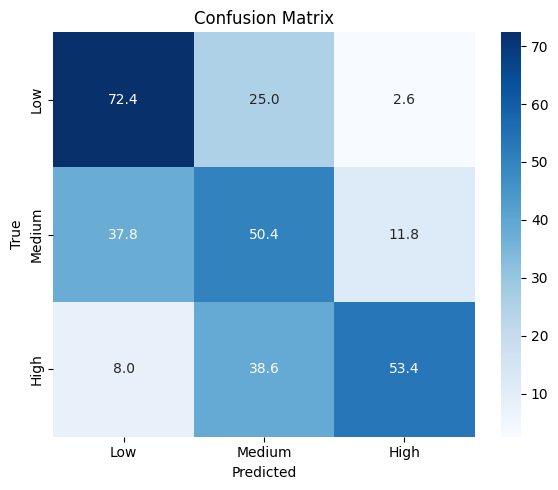

In [16]:
# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Rótulos originais e nomes legíveis
labels = [0, 1, 2]
names = ["Low", "Medium", "High"]

# Gera a matriz de confusão
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Normaliza cada linha para obter porcentagem
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, None] * 100

# Converte para DataFrame para salvar em arquivo
cm_df = pd.DataFrame(cm, index=[f"True_{n}" for n in names],
                        columns=[f"Pred_{n}" for n in names])

# Salva em CSV
cm_df.to_csv("balanced_loss_llm_confusion_matrix.csv", index=True)

# ---------- Gráfico ----------
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=names, yticklabels=names)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

# Salva como imagem
plt.savefig("balanced_loss_llm_confusion_matrix.png")

# Mostra na tela
plt.show()


